<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:
####Get p-values for different correlation coefficients in merged_df
####Extract county-by-county hate crime frequency data

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

In [3]:
ethnicity_race_cols = list(set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"]))
# ethnicity_race_cols

#Data Cleaning

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "County"))]

##Clean county demographic dataset

In [6]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [7]:
#fix the headers
county_demo_df = fixHeaders(county_demo_df)

###Create area columns

In [8]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [9]:
splitArea(county_demo_df)

###Fix column names



In [10]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [11]:
# fix any missing values
county_demo_df = county_demo_df.replace("(X)", np.nan)

In [12]:
#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

drop_cols_containing(county_demo_df, "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED")

In [13]:
# Drop columns that only contain NaN values
new_county_df = county_demo_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_demo_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_demo_df = new_county_df

print(ethnicity_race_cols)

# Drop rows with NaN values in any of the ethnicity_race_cols
county_demo_df.dropna(subset=ethnicity_race_cols, how='any', inplace=True)

['Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone', 'Percent!!Race alone or in combination with one or more other races!!Black or African American', 'Percent!!Race alone or in combination with one or more other races!!Asian', 'Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan', 'Percent!!RACE!!Two or More Races!!White and Some Other Race', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian', 'Percent!!RACE!!One race!!Black or African American', 'Percent!!RACE!!Two or More Races!!White and Asian', 'Percent!!Race alone or in combination with one or more other races!!Native Hawaiian and Other Pacific Islander', 'Percent!!Race alone or in combination with one or more other races!!American Indian and Alaska Native', 'Per

###Fix column data types

In [14]:
counts = county_demo_df.columns.value_counts()
mask = counts > 1
duplicates = list(counts[mask].index)
county_demo_df[duplicates].dtypes

RACE!!Two or More Races             object
RACE!!Two or More Races             object
65 years and over                   object
65 years and over                   object
18 years and over                   object
18 years and over                   object
Percent!!65 years and over          object
Percent!!65 years and over          object
Percent!!18 years and over          object
Percent!!18 years and over          object
Percent!!RACE!!One race             object
Percent!!RACE!!One race             object
Percent!!RACE!!Two or More Races    object
Percent!!RACE!!Two or More Races    object
RACE!!One race                      object
RACE!!One race                      object
dtype: object

In [15]:
county_demo_df = county_demo_df.loc[:, ~county_demo_df.columns.duplicated(keep='last')]

In [18]:
county_percent_age_cols = list(set(list(county_demo_df.filter(regex = "Percent"))\
                                  + list(county_demo_df.filter(regex = "ratio"))\
                                  + list(county_demo_df.filter(regex = "years"))))

for column in county_percent_age_cols:
    contaminated_indices_mask = county_demo_df[column]\
                                  .astype(str)\
                                  .str\
                                  .contains('N')
    county_demo_df.loc[contaminated_indices_mask, column] = 0

<ipython-input-18-a83d6a237370>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df.loc[contaminated_indices_mask, column] = 0
<ipython-input-18-a83d6a237370>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df.loc[contaminated_indices_mask, column] = 0
<ipython-input-18-a83d6a237370>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df.loc[contaminated_indices_mask, column] = 0
<ipython-input-18-a

In [19]:
county_demo_df[county_percent_age_cols] = county_demo_df[county_percent_age_cols].astype(float)

<ipython-input-19-5814d5ada3aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df[county_percent_age_cols] = county_demo_df[county_percent_age_cols].astype(float)


In [20]:
county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)

<ipython-input-20-b5997834eea0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)


In [21]:
# Convert the quantitative columns to int types
# continuous quantitative variables
continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over"] + ethnicity_race_cols

county_demo_df[continuous_int_columns].replace("N", 0, inplace=True)


county_demo_df[continuous_int_columns] = county_demo_df[continuous_int_columns].astype(int)

<ipython-input-21-7602301e0127>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df[continuous_int_columns].replace("N", 0, inplace=True)
<ipython-input-21-7602301e0127>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_demo_df[continuous_int_columns] = county_demo_df[continuous_int_columns].astype(int)


In [22]:
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', '85 years and over']

In [23]:
county_demo_df["Geography"].count()

848

##Clean crime dataset

In [24]:
crime_df.head()

incident_id  data_year        ori pug_agency_name pub_agency_unit  \
230026      1433145       2022  AL0020000          Mobile             NaN   
230031      1433182       2022  AL0010000       Jefferson             NaN   
230032      1433188       2022  AL0010000       Jefferson             NaN   
230038      1465987       2022  AL0620000      Tallapoosa             NaN   
230041      1466003       2022  AL0290000          Elmore             NaN   

       agency_type_name state_abbr state_name       division_name region_name  \
230026           County         AL    Alabama  East South Central       South   
230031           County         AL    Alabama  East South Central       South   
230032           County         AL    Alabama  East South Central       South   
230038           County         AL    Alabama  East South Central       South   
230041           County         AL    Alabama  East South Central       South   

       population_group_code              population_group_description  \
230026                    9A              MSA counties 100,000 or over   
230031                    9A              MSA counties 100,000 or over   
230032                    9A              MSA counties 100,000 or over   
230038                    8C  Non-MSA counties from 10,000 thru 24,999   
230041                    9B      MSA counties from 25,000 thru 99,999   

       incident_date  adult_victim_count  juvenile_victim_count  \
230026    2022-03-11                 1.0                    0.0   
230031    2022-02-06                 1.0                    0.0   
230032    2022-03-03                 1.0                    0.0   
230038    2022-01-04                 1.0                    0.0   
230041    2022-02-14                 1.0                    0.0   

        total_offender_count  adult_offender_count  juvenile_offender_count  \
230026                     2                   2.0                      0.0   
230031                     2                   2.0                      0.0   
230032                     2                   2.0                      0.0   
230038                     1                   1.0                      0.0   
230041                     0                   NaN                      NaN   

                    offender_race      offender_ethnicity  victim_count  \
230026                      White  Not Hispanic or Latino             1   
230031                    Unknown           Not Specified             1   
230032  Black or African American  Not Hispanic or Latino             1   
230038  Black or African American  Not Hispanic or Latino             1   
230041              Not Specified           Not Specified             1   

                        offense_name  total_individual_victims  \
230026                Simple Assault                       1.0   
230031           Theft From Building                       1.0   
230032                  Intimidation                       1.0   
230038            Aggravated Assault                       1.0   
230041  Burglary/Breaking & Entering                       1.0   

                                        location_name  \
230026                                 Residence/Home   
230031                                 Residence/Home   
230032                        Parking/Drop Lot/Garage   
230038  Jail/Prison/Penitentiary/Corrections Facility   
230041                                 Residence/Home   

                                        bias_desc victim_types  \
230026  Anti-Asian;Anti-Black or African American   Individual   
230031         Anti-Other Race/Ethnicity/Ancestry   Individual   
230032                            Anti-Gay (Male)   Individual   
230038                                 Anti-White   Individual   
230041                                  Anti-Sikh   Individual   

       multiple_offense multiple_bias  
230026                S             M  
230031                S             S  
230032                S    

###Break up incident date information

In [25]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [26]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [27]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [28]:
crime_df.reset_index(inplace=True)

In [29]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [30]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [31]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [32]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [33]:
other_categorical_cols = ["pug_agency_name", "agency_type_name", "division_name", "offender_race",
                          "offender_ethnicity", "state_name", "multiple_offense", "multiple_bias"]

In [34]:
other_unique_categorical_cols = {}
for col in other_categorical_cols:
    unique_values = crime_df[col].unique()
    other_unique_categorical_cols[col] = [col + "_" + str(val) for val in unique_values]

In [35]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)

other_categorical_cols = dummies.columns

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

##Merge the datasets

In [36]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

In [37]:
merged_df.drop(other_unique_categorical_cols["pug_agency_name"] + ["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

# include offense_name in categorical data once you've refactored multicol parsing

In [38]:
# categorical variables
binary_int_columns = bias_cols + victim_cols + offense_cols + location_cols + list(other_categorical_cols)
int_columns = continuous_int_columns + binary_int_columns + ["incident_month", "incident_day"]

In [39]:
print(int_columns)

['Total population', 'Under 5 years', '5 to 9 years', '45 to 54 years', '10 to 14 years', '75 to 84 years', '60 to 64 years', '25 to 34 years', '15 to 19 years', '20 to 24 years', '35 to 44 years', '55 to 59 years', '65 to 74 years', '85 years and over', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone', 'Percent!!Race alone or in combination with one or more other races!!Black or African American', 'Percent!!Race alone or in combination with one or more other races!!Asian', 'Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan', 'Percent!!RACE!!Two or More Races!!White and Some Other Race', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian', 'Percent!!RACE!!One race!!Black or African American', 'Percent!!RACE!!Two or

#Extract Additional Features

In [40]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        unique_col_counts[value] = df[value].sum()

    return unique_col_counts

##Get hate crime rate per county

In [41]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  230026      1433145       2022  AL0020000          Mobile             NaN   
1  230031      1433182       2022  AL0010000       Jefferson             NaN   
2  230032      1433188       2022  AL0010000       Jefferson             NaN   
3  230038      1465987       2022  AL0620000      Tallapoosa             NaN   
4  230041      1466003       2022  AL0290000          Elmore             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9A              MSA counties 100,000 or over   
1                    9A              MSA counties 100,000 or over   
2                    9A              MSA counties 100,000 or over   
3                    8C  Non-MSA counties from 10,000 thru 24,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2022-03-11                 1.0                    0.0   
1    2022-02-06                 1.0                    0.0   
2    2022-03-03                 1.0                    0.0   
3    2022-01-04                 1.0                    0.0   
4    2022-02-14                 1.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     2                   2.0                      0.0   
2                     2                   2.0                      0.0   
3                     1                   1.0                      0.0   
4                     0                   NaN                      NaN   

               offender_race      offender_ethnicity  victim_count  \
0                      White  Not Hispanic or Latino             1   
1                    Unknown           Not Specified             1   
2  Black or African American  Not Hispanic or Latino             1   
3  Black or African American  Not Hispanic or Latino             1   
4              Not Specified           Not Specified             1   

                   offense_name  total_individual_victims  \
0                Simple Assault                       1.0   
1           Theft From Building                       1.0   
2                  Intimidation                       1.0   
3            Aggravated Assault                       1.0   
4  Burglary/Breaking & Entering                       1.0   

                                   location_name  \
0                                 Residence/Home   
1                                 Residence/Home   
2                        Parking/Drop Lot/Garage   
3  Jail/Prison/Penitentiary/Corrections Facility   
4                                 Residence/Home   

                                   bias_desc victim_types multiple_offense  \
0  Anti-Asian;Anti-Black or African American   Individual                S   
1         Anti-Other Race/Ethnicity/Ancestry   Individual                S   
2                            Anti-Gay (Male)   Individual                S   
3                                 Anti-White   Individual                S   
4                                  Anti-Sikh   Individual                S   

  multiple_bias  incident_month  incident_day  \
0             M               3            11   
1             S               2             6   
2             S               3             3   
3             S               1             4   
4             S   

In [42]:
county_hate_counts = get_col_counts(crime_df, other_unique_categorical_cols["pug_agency_name"])
county_hate_counts_df = pd.DataFrame.from_dict(data=county_hate_counts, orient='index', columns=['hate_crime_count'])

In [43]:
county_hate_counts_df.index

Index(['pug_agency_name_Mobile', 'pug_agency_name_Jefferson',
       'pug_agency_name_Tallapoosa', 'pug_agency_name_Elmore',
       'pug_agency_name_Lawrence', 'pug_agency_name_Marshall',
       'pug_agency_name_Russell', 'pug_agency_name_Colbert',
       'pug_agency_name_Chilton', 'pug_agency_name_Houston',
       ...
       'pug_agency_name_Winnebago', 'pug_agency_name_Marinette',
       'pug_agency_name_Crawford', 'pug_agency_name_Mason',
       'pug_agency_name_Cabell', 'pug_agency_name_Monongalia',
       'pug_agency_name_Kanawha', 'pug_agency_name_Brooke',
       'pug_agency_name_Wetzel', 'pug_agency_name_Sweetwater'],
      dtype='object', length=483)

In [44]:
county_hate_counts_df["pug_agency_name"] = county_hate_counts_df.index.str.replace("pug_agency_name_", "")
county_hate_counts_df.head()

hate_crime_count pug_agency_name
pug_agency_name_Mobile                     6          Mobile
pug_agency_name_Jefferson                 41       Jefferson
pug_agency_name_Tallapoosa                 1      Tallapoosa
pug_agency_name_Elmore                     1          Elmore
pug_agency_name_Lawrence                   1        Lawrence

In [45]:
# only include demographic info related to each of the counties in the crime dataset
filtered_county_demo_df = county_demo_df[("pug_agency_name_" + county_demo_df["pug_agency_name"]).isin(county_hate_counts_df.index)]
filtered_county_demo_df["Geography"].count()

414

In [46]:
# merge the 2 datasets
county_hate_rates_df = county_hate_counts_df.merge(filtered_county_demo_df, on="pug_agency_name", how="outer")

In [51]:
county_hate_rates_df.columns

Index(['hate_crime_count', 'pug_agency_name', 'Geography',
       'Geographic Area Name', 'Total population', 'Male', 'Female',
       'Sex ratio (males per 100 females)', 'Under 5 years', '5 to 9 years',
       ...
       'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone',
       'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone',
       'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races',
       'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race',
       'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races',
       'Percent!!Citizen, 18 and over population',
       'Percent!!Citizen, 18 and over population!!Male',
       'Percent!!Citizen, 18 and over population!!Female', 'agency_type_name',
       'state

In [138]:
county_hate_rates_df["hate_crime_rate"] = county_hate_rates_df["hate_crime_count"]\
                                            .divide(county_hate_rates_df["Total population"])\
                                            .astype("float64")

In [139]:
county_hate_rates_df.head()

hate_crime_count pug_agency_name       Geography  \
0                 6          Mobile  0500000US01097   
1                41       Jefferson  0500000US01073   
2                41       Jefferson  0500000US05069   
3                41       Jefferson  0500000US08059   
4                41       Jefferson  0500000US21111   

         Geographic Area Name  Total population    Male  Female  \
0      Mobile County, Alabama          411411.0  197023  214388   
1   Jefferson County, Alabama          665409.0  316006  349403   
2  Jefferson County, Arkansas           64246.0   31983   32263   
3  Jefferson County, Colorado          576143.0  290571  285572   
4  Jefferson County, Kentucky          773399.0  376659  396740   

   Sex ratio (males per 100 females)  Under 5 years  5 to 9 years  \
0                               91.9        25491.0       25092.0   
1                               90.4        40023.0       42312.0   
2                               99.1         3739.0        4994.0   
3                              101.8        26564.0       29406.0   
4                               94.9        46380.0       45120.0   

   10 to 14 years  15 to 19 years  20 to 24 years  25 to 34 years  \
0         27573.0         26649.0         26896.0         57435.0   
1         41999.0         44003.0         45196.0         92953.0   
2          2732.0          3794.0          4903.0          7971.0   
3         29368.0         31900.0         31581.0         88812.0   
4         48082.0         45776.0         49413.0        112594.0   

   35 to 44 years  45 to 54 years  55 to 59 years  60 to 64 years  \
0         50421.0         47563.0         24935.0         27772.0   
1         86752.0         77841.0         36117.0         44527.0   
2          8083.0          7324.0          4370.0          4263.0   
3         87323.0         71526.0         36753.0         39128.0   
4        100646.0         91040.0         45029.0         53114.0   

   65 to 74 years  75 to 84 years  85 years and over  Median age (years)  \
0         42741.0         21289.0             7554.0                37.9   
1         68694.0         31937.0            13055.0                38.1   
2          7322.0          4073.0              678.0                39.8   
3         62327.0         30215.0            11240.0                40.8   
4         81961.0         39414.0            14830.0                38.8   

   Under 18 years  16 years and over  21 years and over  62 years and over  \
0         94979.0           326493.0           299400.0            89201.0   
1        149764.0           532318.0           486856.0           140876.0   
2         13722.0            52202.0            48120.0            15052.0   
3        105197.0           484627.0           452441.0           128742.0   
4        168846.0           623079.0           578271.0           167972.0   

   18 years and over  18 years and over!!Male  18 years and over!!Female  \
0           316432.0                 148763.0                   167669.0   
1           515645.0                 239657.0                   275988.0   
2            50524.0                  24964.0                    25560.0   
3           470946.0                 236503.0                   234443.0   
4           604553.0                 290232.0                   314321.0   

   18 years and over!!Sex ratio (males per 100 females)  65 years and over  \
0                                               88.7               71584.0   
1                                               86.8              113686.0   
2                                               97.7               12073.0   
3                                              100.9              103782.0   
4                                               92.3              136205.0   

   65 years and over!!Male  65 years and over!!Female  \
0                  31511.0                    40073.0   
1                  47695.0                    65991.0   
2

# Data Exploration

##Important Functions

In [59]:
def get_sorted_corrs(corr):
  # Unstack and rename corr
  corr_sorted = pd.DataFrame(corr.unstack()).reset_index()
  corr_sorted.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"corr"}, inplace=True)

  corr_sorted["abs_corr"] = 0

  # Get highest correlation coefficient pairs
  corr_sorted["abs_corr"] = corr_sorted["corr"].abs()
  corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

  #reset the indices
  corr_sorted.reset_index(inplace=True)

  #filter out self-correlations
  corr_sorted = corr_sorted[~(corr_sorted["feature1"] == corr_sorted["feature2"])]

  # remove duplicates
  # only keep even-numbered rows, since there will be 2 of every correlation
  corr_sorted = corr_sorted.iloc[::2]
  # corr_sorted = corr_sorted.dropna().groupby("feature1")

  return corr_sorted

In [105]:
def do_corr_analysis(corr, minThreshold, maxThreshold, blacklistPhraseRegex, corr_sorted=None):
    # get the sorted correlation coefficients
    if corr_sorted is None:
      sorted_corrs = get_sorted_corrs(crime_corr)
    else:
      sorted_corrs = corr_sorted

    # create subplot display
    fig, ax = plt.subplots(3, figsize=(10, 10))

    # plot stuff
    sorted_corrs["corr"].plot.hist(bins=40, logy=True, ax=ax[0], title="Correlation Coefficients")
    sorted_corrs["abs_corr"].plot.hist(bins=40, logy=True, ax=ax[1], title="Correlation Coefficients' Absolute Values")

    # filter down to correlations of interest
    corrs_of_interest = sorted_corrs[(sorted_corrs["abs_corr"] > minThreshold) & (sorted_corrs["abs_corr"] < maxThreshold)
                                      & (~sorted_corrs["feature1"].str.contains(blacklistPhraseRegex))
                                      & (~sorted_corrs["feature2"].str.contains(blacklistPhraseRegex))]

    # plot the remaining correlations
    corrs_of_interest["corr"].plot.hist(bins=40, logy=True, ax=ax[2], title="Correlation Coefficients of Interest")

    return sorted_corrs, corrs_of_interest

##Individual Datasets

###Hate Crime Dataset

In [61]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  230026      1433145       2022  AL0020000          Mobile             NaN   
1  230031      1433182       2022  AL0010000       Jefferson             NaN   
2  230032      1433188       2022  AL0010000       Jefferson             NaN   
3  230038      1465987       2022  AL0620000      Tallapoosa             NaN   
4  230041      1466003       2022  AL0290000          Elmore             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9A              MSA counties 100,000 or over   
1                    9A              MSA counties 100,000 or over   
2                    9A              MSA counties 100,000 or over   
3                    8C  Non-MSA counties from 10,000 thru 24,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2022-03-11                 1.0                    0.0   
1    2022-02-06                 1.0                    0.0   
2    2022-03-03                 1.0                    0.0   
3    2022-01-04                 1.0                    0.0   
4    2022-02-14                 1.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     2                   2.0                      0.0   
2                     2                   2.0                      0.0   
3                     1                   1.0                      0.0   
4                     0                   NaN                      NaN   

               offender_race      offender_ethnicity  victim_count  \
0                      White  Not Hispanic or Latino             1   
1                    Unknown           Not Specified             1   
2  Black or African American  Not Hispanic or Latino             1   
3  Black or African American  Not Hispanic or Latino             1   
4              Not Specified           Not Specified             1   

                   offense_name  total_individual_victims  \
0                Simple Assault                       1.0   
1           Theft From Building                       1.0   
2                  Intimidation                       1.0   
3            Aggravated Assault                       1.0   
4  Burglary/Breaking & Entering                       1.0   

                                   location_name  \
0                                 Residence/Home   
1                                 Residence/Home   
2                        Parking/Drop Lot/Garage   
3  Jail/Prison/Penitentiary/Corrections Facility   
4                                 Residence/Home   

                                   bias_desc victim_types multiple_offense  \
0  Anti-Asian;Anti-Black or African American   Individual                S   
1         Anti-Other Race/Ethnicity/Ancestry   Individual                S   
2                            Anti-Gay (Male)   Individual                S   
3                                 Anti-White   Individual                S   
4                                  Anti-Sikh   Individual                S   

  multiple_bias  incident_month  incident_day  \
0             M               3            11   
1             S               2             6   
2             S               3             3   
3             S               1             4   
4             S   

####Correlation matrix

In [62]:
crime_numerical_columns = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_columns:
    crime_numerical_columns.remove(item)

In [63]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_columns].dropna().corr()

In [ ]:
# # Set the figure size
# plt.figure(figsize=(200, 100))

# # Create a heatmap of the correlation matrix
# sns.heatmap(crime_corr, annot=True)

# # Show the plot
# plt.show()

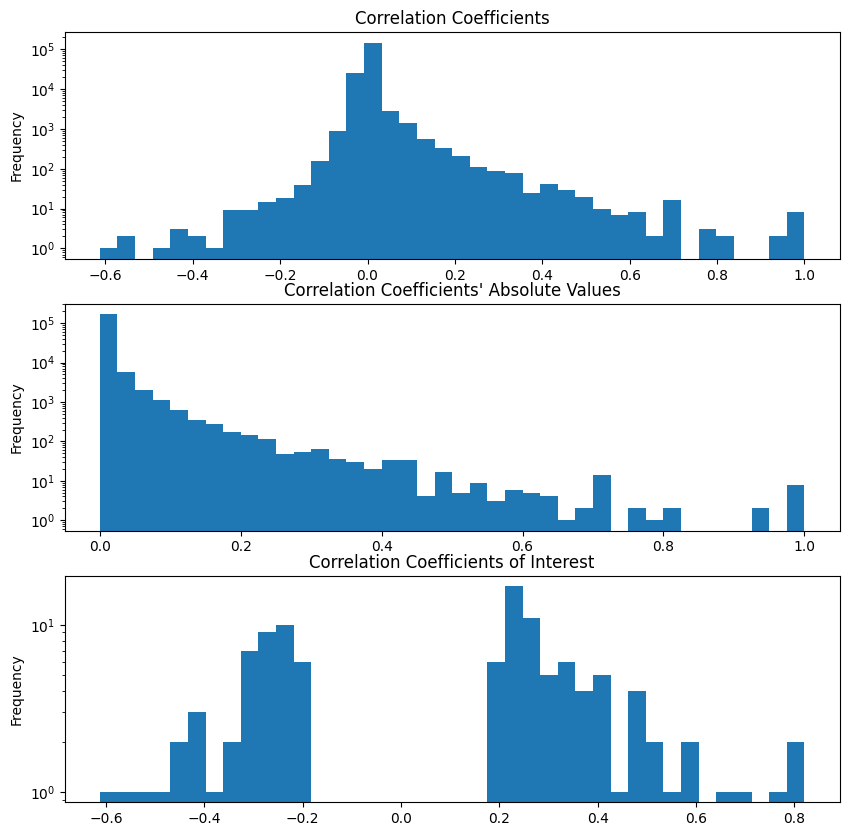

In [106]:
sorted_crime_corrs, crime_corrs_of_interest = do_corr_analysis(crime_corr, 0.2, 0.9, "pug_agency_name|state_name")

In [ ]:
crime_corrs_of_interest

####Quantitative variable figures

In [ ]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

In [ ]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

In [ ]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [ ]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


In [ ]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

In [ ]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

In [ ]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

In [ ]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

In [ ]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

In [ ]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [ ]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [ ]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

In [ ]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        # Sum of occurrences of victim_race in the region
        count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [ ]:
county_demo_df.head()

####Correlation matrix

In [82]:
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [83]:
# Create a correlation matrix
county_corr = county_demo_df[county_numerical_cols].corr()

In [ ]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(county_corr, annot=True)

# # Show the plot
# plt.show()

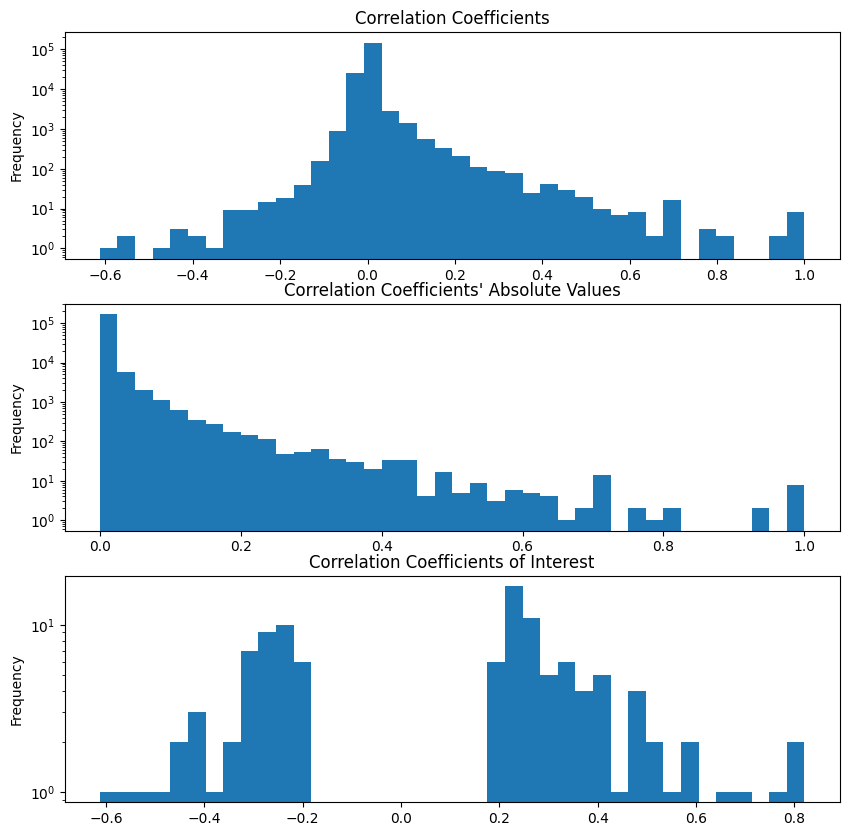

In [107]:
sorted_county_corrs, county_corrs_of_interest = do_corr_analysis(county_corr, 0.2, 0.9, "pug_agency_name|state_name")

####Other figures

In [ ]:
county_demo_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.8, figsize=(16,8))

In [ ]:
county_demo_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

In [ ]:
county_hate_counts_df["hate_crime_count"].sort_values(ascending=True).plot.barh(logx=True, figsize=(10, 100))

##Merged Datasets

In [ ]:
merged_df.head()

###Primary Merged Dataset

####Correlation Matrix Analysis

In [87]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["index", "incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = list(categorical_to_int_df.columns)
# numerical_cols

In [88]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

In [98]:
merged_corr_sorted = get_sorted_corrs(merged_corr)
merged_corr_sorted.head()

index                          feature1  \
62   40865         division_name_New England   
152  76780   Percent!!RACE!!Total population   
171  76697   Percent!!RACE!!Total population   
178  75216  Percent!!18 years and over!!Male   
181  75803        Percent!!65 years and over   

                                              feature2  corr  abs_corr  
62                                    state_name_Maine   1.0       1.0  
152  Percent!!Race alone or in combination with one...   1.0       1.0  
171                                   Total population   1.0       1.0  
178                 Percent!!18 years and over!!Female  -1.0       1.0  
181                                  65 years and over   1.0       1.0

In [99]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_columns)

merged_corr_sorted = merged_corr_sorted[~(
    ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [100]:
merged_corr_sorted.head()

index               feature1  \
1407  41280  division_name_Pacific   
1409  48333     state_name_Florida   
1447  47386  state_name_California   
1485  48332     state_name_Florida   
1505  47396  state_name_California   

                                               feature2      corr  abs_corr  
1407  Percent!!RACE!!Two or More Races!!White and Asian  0.682364  0.682364  
1409  Percent!!HISPANIC OR LATINO AND RACE!!Hispanic...  0.682040  0.682040  
1447           Percent!!RACE!!One race!!Asian!!Filipino  0.649849  0.649849  
1485  Percent!!HISPANIC OR LATINO AND RACE!!Hispanic...  0.635941  0.635941  
1505           Percent!!RACE!!One race!!Some Other Race  0.628514  0.628514

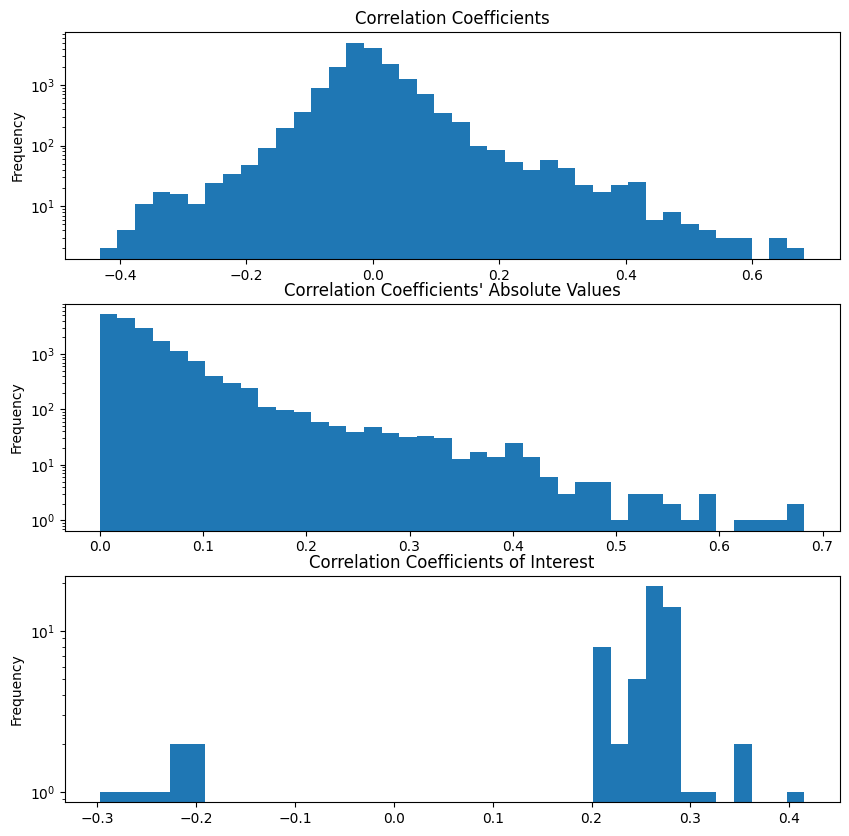

In [108]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corr_sorted, merged_corrs_of_interest = do_corr_analysis(merged_corr, 0.2, 1, "state_name|division_name", merged_corr_sorted)

In [ ]:
merged_corrs_of_interest

####Other Figures

In [ ]:
#blah

###County Feature Prediction Dataset

####Correlation Analysis

In [140]:
hate_rate_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)
hate_rate_corr = county_hate_rates_df[hate_rate_numerical_cols + ["hate_crime_count", "hate_crime_rate"]].corr()

In [141]:
hate_rate_corr.head()

Total population  \
Total population                           1.000000   
Sex ratio (males per 100 females)         -0.048852   
Under 5 years                              0.990689   
5 to 9 years                               0.989920   
10 to 14 years                             0.993321   

                                   Sex ratio (males per 100 females)  \
Total population                                           -0.048852   
Sex ratio (males per 100 females)                           1.000000   
Under 5 years                                              -0.049104   
5 to 9 years                                               -0.042359   
10 to 14 years                                             -0.040215   

                                   Under 5 years  5 to 9 years  \
Total population                        0.990689      0.989920   
Sex ratio (males per 100 females)      -0.049104     -0.042359   
Under 5 years                           1.000000      0.997706   
5 to 9 years                            0.997706      1.000000   
10 to 14 years                          0.994914      0.995445   

                                   10 to 14 years  15 to 19 years  \
Total population                         0.993321        0.994344   
Sex ratio (males per 100 females)       -0.040215       -0.043353   
Under 5 years                            0.994914        0.992214   
5 to 9 years                             0.995445        0.994050   
10 to 14 years                           1.000000        0.996960   

                                   20 to 24 years  25 to 34 years  \
Total population                         0.992132        0.994797   
Sex ratio (males per 100 females)       -0.044565       -0.036492   
Under 5 years                            0.986069        0.987593   
5 to 9 years                             0.986011        0.984469   
10 to 14 years                           0.988811        0.986724   

                                   35 to 44 years  45 to 54 years  \
Total population                         0.997610        0.997945   
Sex ratio (males per 100 females)       -0.035975       -0.043862   
Under 5 years                            0.990254        0.984729   
5 to 9 years                             0.989308        0.984737   
10 to 14 years                           0.991657        0.990220   

                                   55 to 59 years  60 to 64 years  \
Total population                         0.995938        0.994527   
Sex ratio (males per 100 females)       -0.055921       -0.064862   
Under 5 years                            0.979238        0.975395   
5 to 9 years                             0.978523        0.974844   
10 to 14 years                           0.985097        0.981105   

                                   65 to 74 years  75 to 84 years  \
Total population                         0.989259        0.968460   
Sex ratio (males per 100 females)       -0.074232       -0.079536   
Under 5 years                            0.968094        0.940539   
5 to 9 years                             0.967020        0.938976   
10 to 14 years                           0.972412        0.945992   

                                   85 years and over  Median age (years)  \
Total population                            0.955919           -0.135196   
Sex ratio (males per 100 females)          -0.078013           -0.056757   
Under 5 years                               0.919333           -0.180834   
5 to 9 years                                0.915896           -0.174961   
10 to 14 years                              0.926640           -0.169570   

                                   Under 18 years  16 years and over  \
Total population                         0.993059           0.999608   
Sex ratio (males per 100 females)       -0.043027          -0.049990   
Under 5 years                            0.998247           0.986792   
5 to 9 years                             0.998861     

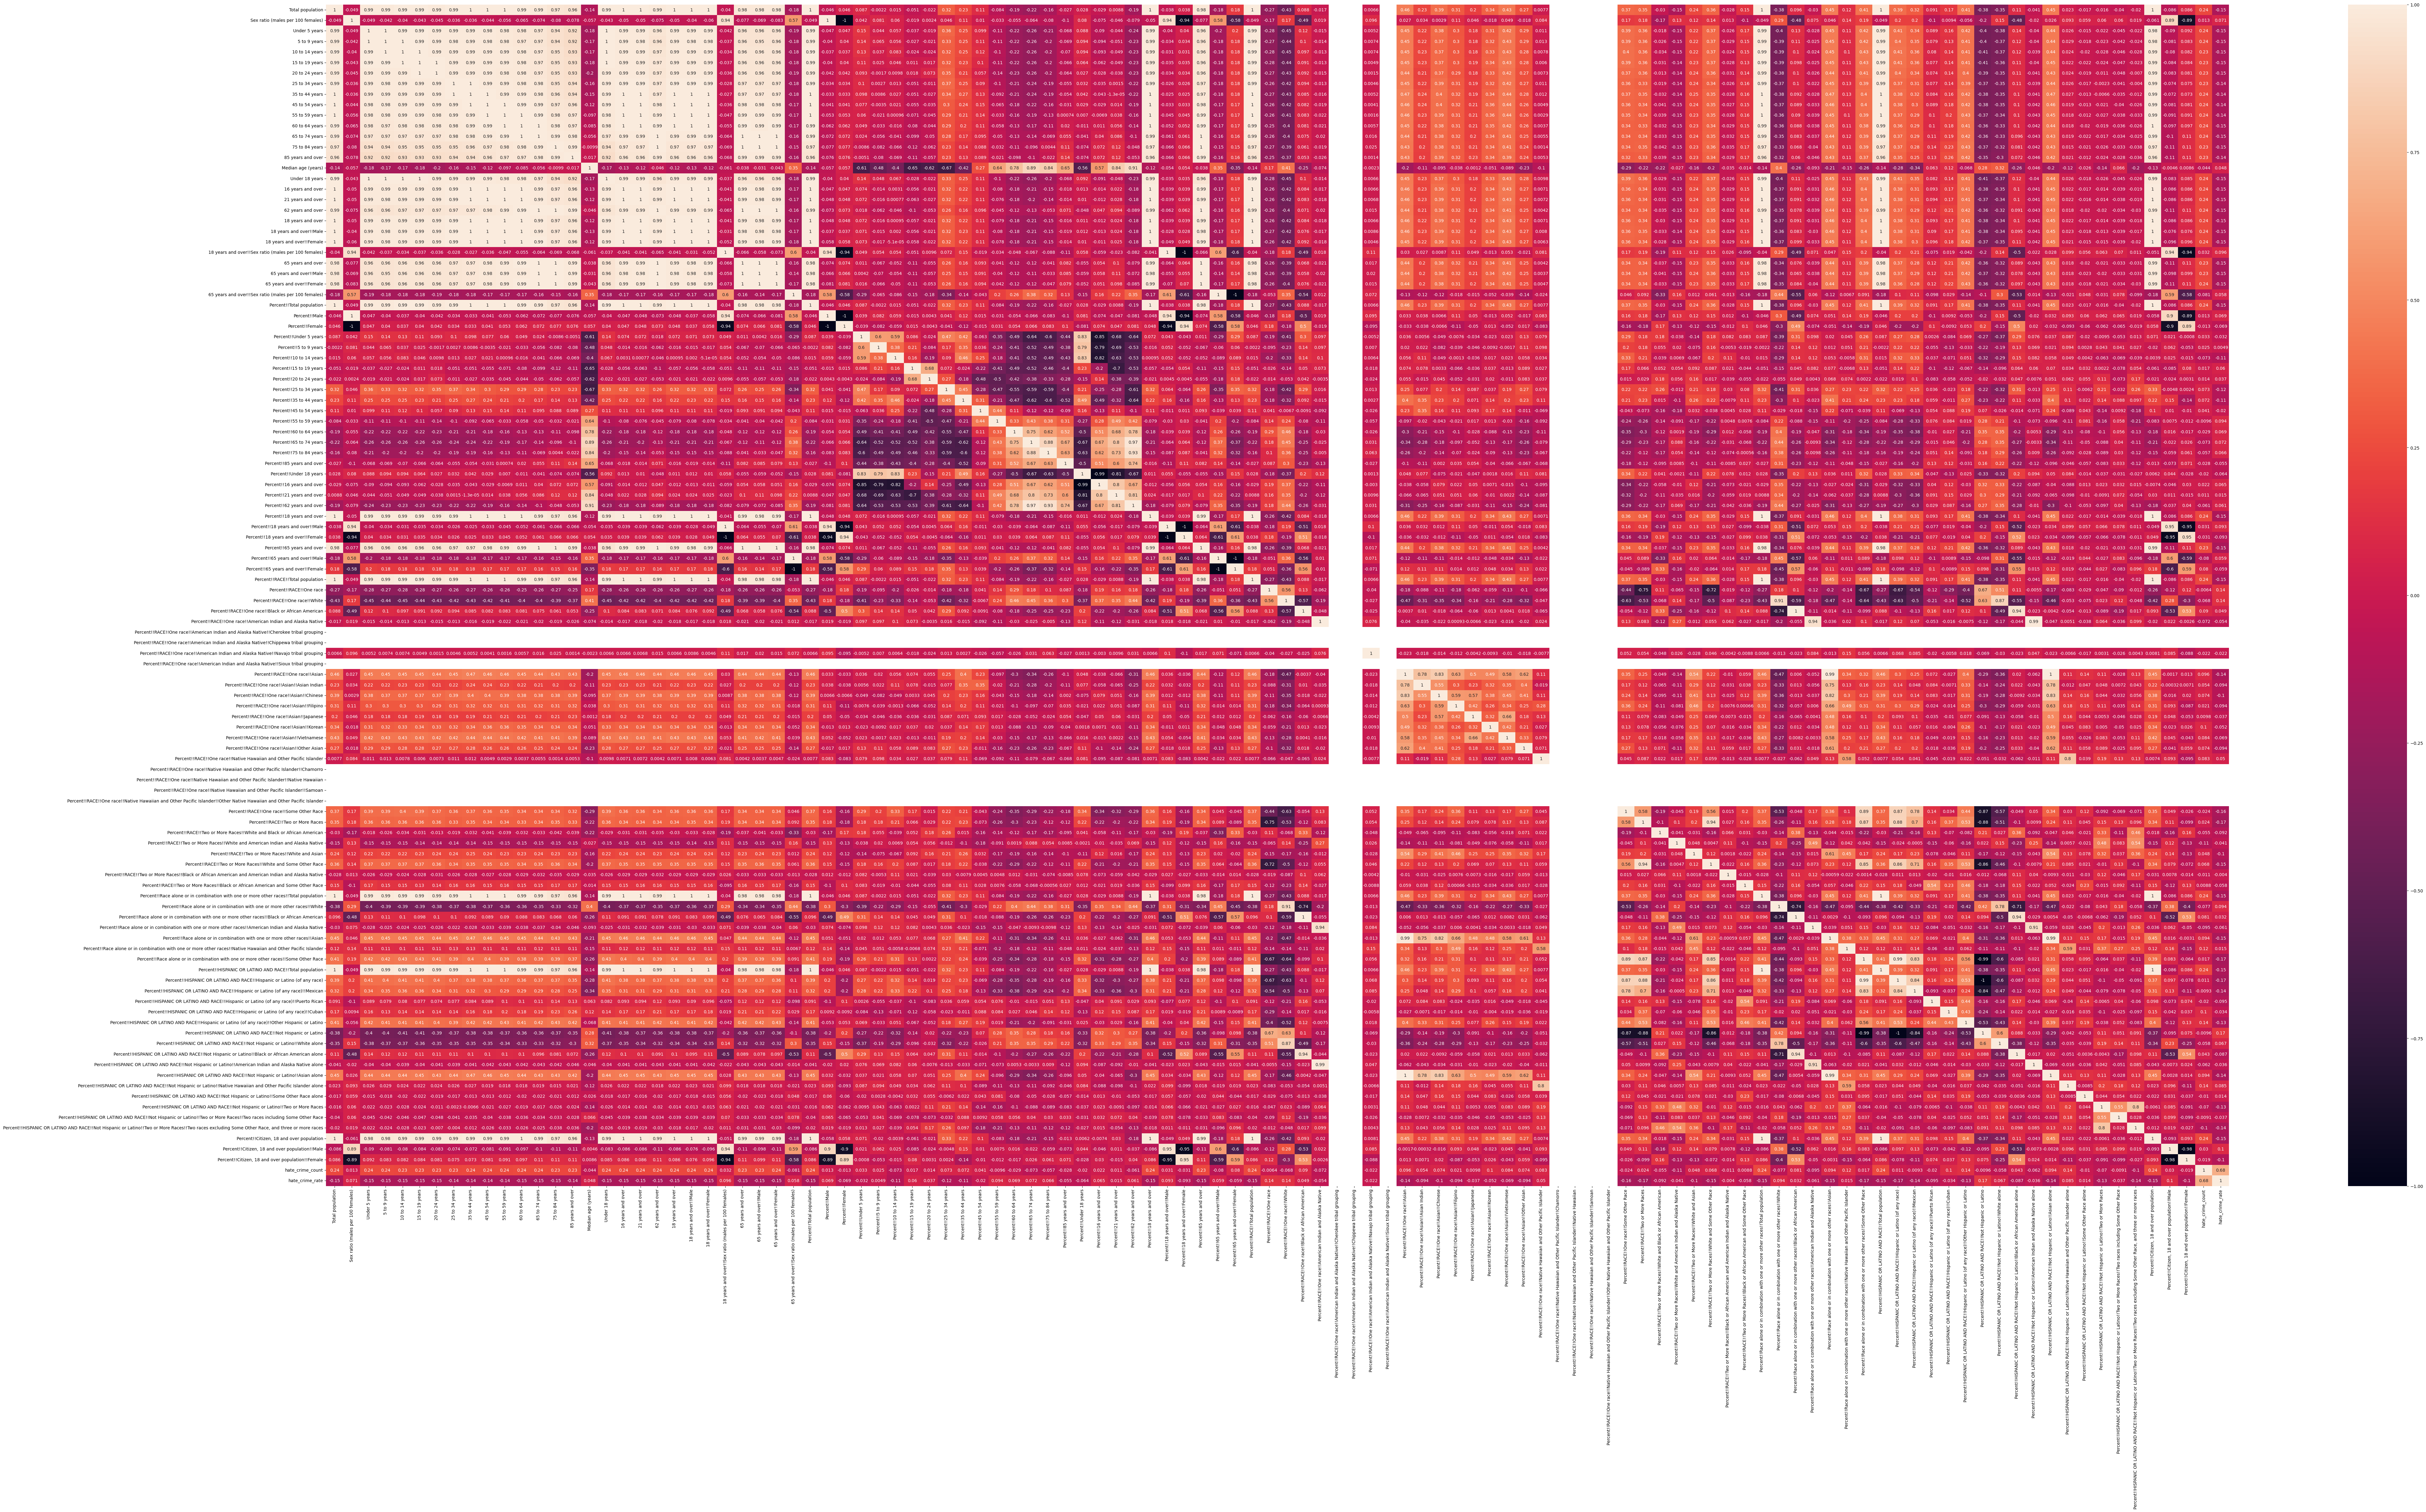

In [145]:
# Set the figure size
plt.figure(figsize=(100, 50))

# Create a heatmap of the correlation matrix
sns.heatmap(hate_rate_corr, annot=True)

# Show the plot
plt.show()

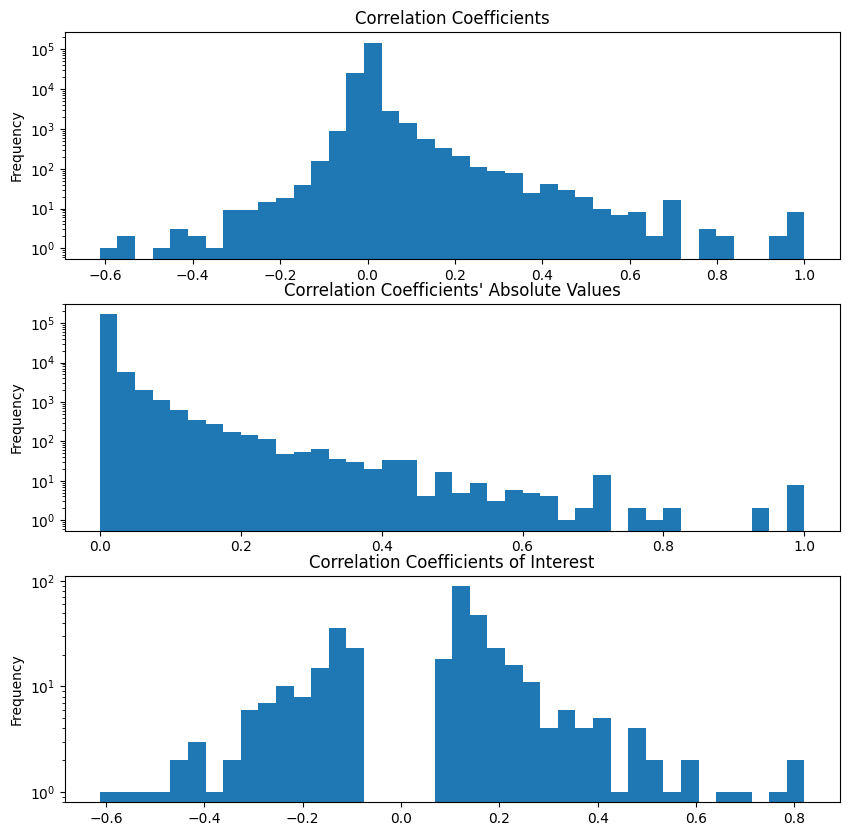

In [143]:
extracted_sorted_corrs, extracted_corrs_of_interest = do_corr_analysis(hate_rate_corr, 0.1, 1.01, "state_name|division_name|pug_agency_name")

In [144]:
extracted_corrs_of_interest

index                                           feature1  \
617        6                                 adult_victim_count   
621     3401                                       victim_count   
623    63874       location_name_Church/Synagogue/Temple/Mosque   
657     3395                                       victim_count   
659    33330                        victim_types_Society/Public   
671   426355                                offender_race_White   
683    59778                       location_name_Amusement Park   
685    11661              bias_desc_Anti-Church of Jesus Christ   
693    32627                victim_types_Religious Organization   
705   429758                         offender_ethnicity_Unknown   
711    33316                        victim_types_Society/Public   
713    39431             offense_name_Drug Equipment Violations   
719    60457   location_name_Arena/Stadium/Fairgrounds/Coliseum   
743    30561                            victim_types_Individual   
747     2718                            juvenile_offender_count   
751   426359                                offender_race_White   
755    23859                     bias_desc_Anti-Other Christian   
759    57085                 offense_name_Weapon Law Violations   
767      683                              juvenile_victim_count   
807    29242                              victim_types_Business   
817   429079                   offender_ethnicity_Not Specified   
829     2041                               adult_offender_count   
837   427093                        offender_ethnicity_Multiple   
841     2838                            juvenile_offender_count   
845   423019                             offender_race_Multiple   
847    44891                          offense_name_Intimidation   
849     2039                               adult_offender_count   
855    71362                          location_name_Field/Woods   
909    30614                            victim_types_Individual   
935    41482  offense_name_False Pretenses/Swindle/Confidenc...   
937    42838  offense_name_Human Trafficking, Involuntary Se...   
945       45                                 adult_victim_count   
951    82839          location_name_School-Elementary/Secondary   
953      679                              juvenile_victim_count   
963     4072                                       victim_count   
975    10289                            bias_desc_Anti-Buddhist   
977    20474                                bias_desc_Anti-Male   
989    61845                location_name_Bank/Savings and Loan   
1015  429754                         offender_ethnicity_Unknown   
1061    9505                            bias_desc_Anti-Bisexual   
1065  428396          offender_ethnicity_Not Hispanic or Latino   
1073   39427             offense_name_Drug Equipment Violations   
1075    2159                               adult_offender_count   
1081   33277                        victim_types_Society/Public   
1137   51712                           offense_name_Shoplifting   
1143   30603                            victim_types_Individual   
1145   30601                            victim_types_Individual   
1157   30599                            victim_types_Individual   
1165  421082     offender_race_American Indian or Alaska Native   
1193   62491                        location_name_Bar/Nightclub   
1217   38747  offense_name_Destruction/Damage/Vandalism of P...   
1221   30649                            victim_types_Individual   
1223     682                              juvenile_victim_count   
1285  429759                         offender_ethnicity_Unknown   
1289   51647                           offense_name_Shoplifting   
1291   25171                      bias_desc_Anti-Other Religion   
1293   82838          location_name_School-Elementary/Secondary   
1313       3                                 adult_victim_count   
1323   38780  offense_name_Destruction/Damage/Vandalis